In [2]:
#前置作業 : 各種import、設定SEED

In [3]:
%%capture
"""
在Python中，%%capture 是一個魔術命令（Magic Command），用於捕獲並抑制輸出。
比如說，這樣寫的話下面安裝的過程就會被隱藏。
"""
!pip install geopandas folium

In [4]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5}'.format #小數點後保留5位
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # You can ignore the Shapely GEOS warning :-)

In [5]:
#set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [6]:
#Loading and previewing data

In [7]:
DATA_PATH = 'D:/kaggle/input4'
#Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

#Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.00010834,0.60302,-6.5331e-05,0.25567,-98.594,...,3664.4,6.1086e+04,2615.1,15.569,0.27229,-12.629,35.632,-138.79,30.752,3.751
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,2.0527e-05,0.72821,1.361e-05,0.13099,16.593,...,3651.2,6.6969e+04,3174.6,8.6906,0.25683,30.359,39.558,-145.18,27.252,4.0252
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.00051414,0.7482,0.00038468,0.11002,72.796,...,4217.0,6.0069e+04,3516.3,21.103,0.2511,15.378,30.402,-142.52,26.193,4.2314
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.5,5.1065e+04,4181.0,15.387,0.26204,-11.293,24.38,-132.67,28.829,4.3053
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-7.8766e-05,0.6763,-4.7624e-05,0.12116,4.1213,...,3980.6,6.3751e+04,3355.7,8.1147,0.23585,38.532,37.393,-141.51,22.205,4.3473


In [8]:
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,3.6022e+04,8472.3,4.1048e+04,7472.3,7.9356,0.24077,-100.11,33.697,-133.05,33.78
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.00045592,0.69116,0.00031558,0.0,76.239,...,4.854e+04,6476.1,5.4916e+04,5476.1,11.448,0.29312,-30.51,42.403,-138.63,31.012
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.00016056,0.60511,0.00010582,0.07987,-42.055,...,3.4133e+04,8984.8,3.9006e+04,7984.8,10.753,0.26713,39.087,45.936,-144.78,26.743
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.00034998,0.69692,0.00024311,0.20103,72.17,...,5.0855e+04,6014.7,5.7646e+04,5014.7,11.765,0.30468,-24.465,42.14,-135.03,29.605
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.00031696,0.58053,-0.000184,0.20435,76.191,...,4.6595e+04,6849.3,5.2897e+04,5849.3,13.065,0.28422,-12.908,30.123,-135.5,26.277


In [9]:
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94
1,ID_-0.510_29.290_2022_01,81.94
2,ID_-0.510_29.290_2022_02,81.94
3,ID_-0.510_29.290_2022_03,81.94
4,ID_-0.510_29.290_2022_04,81.94


In [10]:
train.shape, test.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [11]:
#Train to test sets ratio
(test.shape[0])/(train.shape[0]+test.shape[0])

0.23557692307692307

In [12]:
#Statistical summaries

In [13]:
#Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,7.9023e+04,7.9023e+04,7.9023e+04,7.9023e+04,6.4414e+04,6.4414e+04,6.4414e+04,6.4414e+04,6.4414e+04,...,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.9023e+04
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.8911,29.88,2020.0,26.0,4.7882e-05,0.83485,3.5049e-05,0.15842,-7.9259,...,5592.4,5.942e+04,4670.4,19.139,0.27146,-10.785,40.437,-86.801,27.926,81.941
std,NaN,0.69452,0.81038,0.8165,15.297,0.00027203,0.18538,0.00020559,0.071364,64.263,...,1428.5,9051.2,1359.3,13.547,0.049434,30.374,6.4282,37.837,4.4038,144.3
min,NaN,-3.299,28.228,2019.0,0.0,-0.00099624,0.24182,-0.00088714,0.0,-179.54,...,1050.7,2.4779e+04,1050.5,1.8445,0.017697,-102.74,2.9989,-153.46,10.818,0.0
25%,NaN,-2.451,29.262,2019.0,13.0,-9.5833e-05,0.70582,-7.7857e-05,0.11053,-56.782,...,4595.4,5.3176e+04,3680.9,9.9746,0.24145,-30.309,35.83,-125.99,24.687,9.798
50%,NaN,-1.882,29.883,2020.0,26.0,2.3694e-05,0.80912,1.8628e-05,0.16185,-12.442,...,5573.9,5.9333e+04,4621.8,15.131,0.27275,-12.674,41.12,-84.644,28.334,45.593
75%,NaN,-1.303,30.471,2021.0,39.0,0.00015305,0.94279,0.00012068,0.21182,72.06,...,6542.3,6.5664e+04,5573.0,23.785,0.30289,9.4022,44.446,-48.133,31.5,109.55


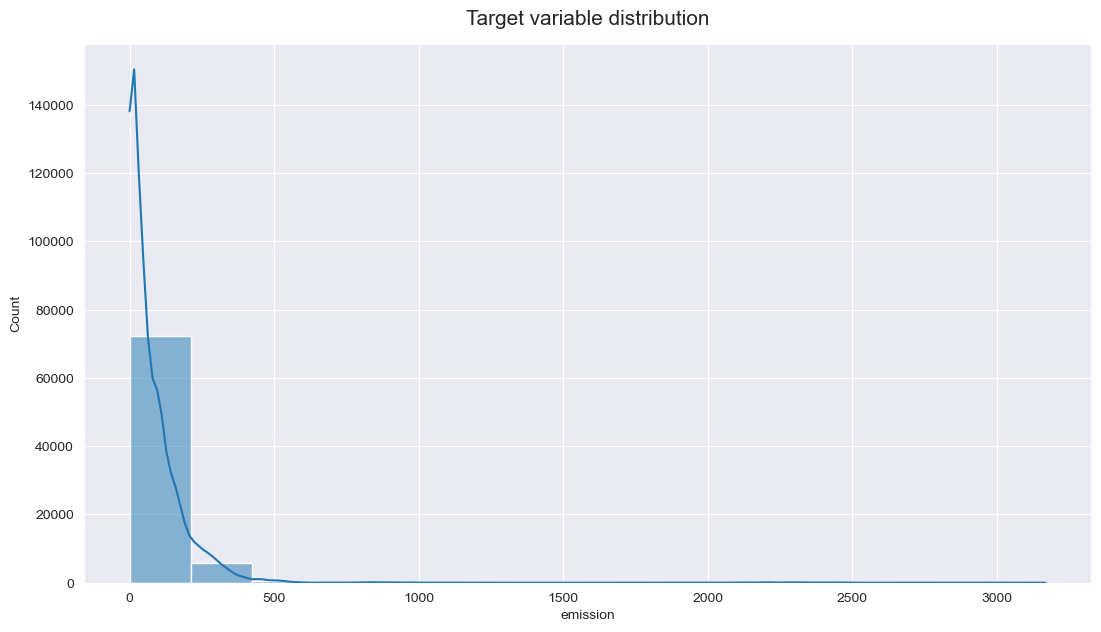

None

10.173825825101622

In [14]:
#Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15) #KDE(核密度估計)就是把長條圖畫成折線圖而已
#KDE的優點就是摺線圖彼長條途更好做比較
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

In [15]:
#Outliers

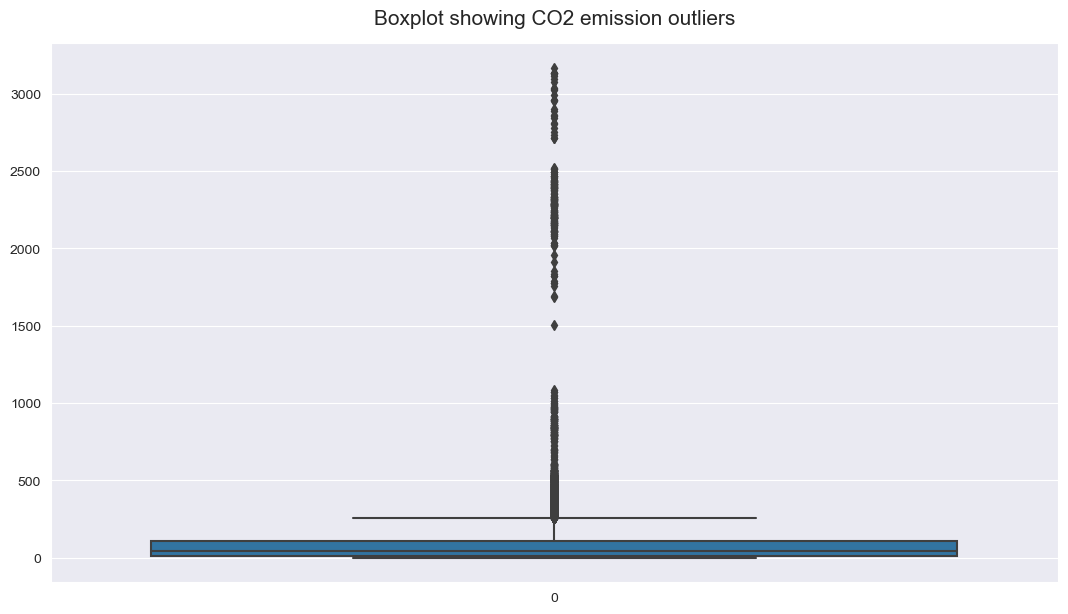

In [16]:
#Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13,7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)
plt.show()

In [17]:
"""
Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:

Transforming the outliers by scaling - log transformation, box-cox transformation ...
Dropping outliers
Imputation by replacing outliers with mean, median ...
"""

'\nOutliers are those data points which differ significantly from other observations present in given dataset.\n\nSuggestions on how to handle outliers:\n\nTransforming the outliers by scaling - log transformation, box-cox transformation ...\nDropping outliers\nImputation by replacing outliers with mean, median ...\n'

In [18]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude']) #drop_duplicate 去掉重複出現的經緯度
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude']) #drop_duplicate 去掉重複出現的經緯度
train_coords['set_type'], test_coords['set_type'] = 'train', 'test' #這裡添加了一個欄set_type，表示數據是訓練集還是測試集。

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
#create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(all_data[["latitude", "longitude", "set_type"]], geometry = geometry)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-0.51,29.29,train,POINT (29.29000 -0.51000)
1,-0.528,29.472,train,POINT (29.47200 -0.52800)
2,-0.547,29.653,train,POINT (29.65300 -0.54700)
3,-0.569,30.031,train,POINT (30.03100 -0.56900)
4,-0.598,29.102,train,POINT (29.10200 -0.59800)


In [19]:
"""
Q. 這裡的geometry是幹嘛的?
Ans. 在這段程式碼中，geometry 是用來創建地理點幾何（geometric points）的一個重要變數。程式碼的主要目的是將訓練數據和測試數據中的經緯度座標（latitude 和 longitude）轉換成地理點的幾何表示，然後將這些地理點與其他相關數據一起放入 GeoDataFrame（一種用於處理地理數據的 Pandas DataFrame 的擴展）。以下是詳細說明：

train_coords 和 test_coords：將訓練數據和測試數據分別按照經緯度座標去重，因為可能有相同的經緯度出現多次。

all_data：將處理過的訓練和測試數據合併成一個新的 DataFrame，並在其中添加了一個列 set_type，表示數據是訓練集還是測試集。

geometry：這個變數創建了地理點的幾何表示，使用 gpd.points_from_xy 函式將經緯度座標轉換為點的幾何表示。

geo_df：使用 GeoDataFrame 創建了一個地理數據框，包含了原始的經緯度座標數據、set_type 列，以及前面創建的 geometry 列，這個列存儲了地理點的幾何表示。

總之，geometry 在這個上下文中是用來創建地理點的幾何表示，以便於將經緯度座標數據轉換為地理數據，並進一步進行地理空間分析和可視化。

"""
#我的想法是 : 要把圖用gis的工具畫出來，首先經緯度資料必須先轉成"幾何表示"。

'\nQ. 這裡的geometry是幹嘛的?\nAns. 在這段程式碼中，geometry 是用來創建地理點幾何（geometric points）的一個重要變數。程式碼的主要目的是將訓練數據和測試數據中的經緯度座標（latitude 和 longitude）轉換成地理點的幾何表示，然後將這些地理點與其他相關數據一起放入 GeoDataFrame（一種用於處理地理數據的 Pandas DataFrame 的擴展）。以下是詳細說明：\n\ntrain_coords 和 test_coords：將訓練數據和測試數據分別按照經緯度座標去重，因為可能有相同的經緯度出現多次。\n\nall_data：將處理過的訓練和測試數據合併成一個新的 DataFrame，並在其中添加了一個列 set_type，表示數據是訓練集還是測試集。\n\ngeometry：這個變數創建了地理點的幾何表示，使用 gpd.points_from_xy 函式將經緯度座標轉換為點的幾何表示。\n\ngeo_df：使用 GeoDataFrame 創建了一個地理數據框，包含了原始的經緯度座標數據、set_type 列，以及前面創建的 geometry 列，這個列存儲了地理點的幾何表示。\n\n總之，geometry 在這個上下文中是用來創建地理點的幾何表示，以便於將經緯度座標數據轉換為地理數據，並進一步進行地理空間分析和可視化。\n\n'

In [20]:
# Create a canvas to plot your map on
#這裡用Folium庫創建一個可互動的地圖，用canvas 引擎驅動
all_data_map = folium.Map(prefer_canvas=True) 

#Create a geometry list from the GeoDataFrame
geo_df_list = [ [point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry ]

#Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    #assign a color maker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"
    
    # Place the markers
    all_data_map.add_child(
        folium.CircleMarker(
        location = coordinates,
            radius = 1,
            weight = 4,
            zoom = 10,
            popup = 
            "Set :" + str([round(x,2) for x in geo_df_list[i]]),
            color = type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

In [21]:

#看有沒有缺失的value?
"""
這個程式碼的意思是檢查在名為 train 的 Pandas DataFrame 中是否存在任何具有缺失值的列。讓我們來解釋一下每個部分的含義：

train：這是一個名稱為 train 的 Pandas DataFrame，表示你的訓練資料集。

.isnull()：這是一個 DataFrame 方法，用於檢查每個元素是否為缺失值 (NaN)。它會返回一個具有相同形狀的新 DataFrame，其中的元素值是布林值（True 或 False），表示對應的元素是否為缺失值。

.sum()：這是一個 DataFrame 方法，用於計算每一"欄"的總和。因為布林值在計算時被視為 1（True）和 0（False），所以對布林值進行求和會得到該列中 True 的總數，也就是該列中缺失值的數量。

.any()：這是一個 Series 方法，用於檢查 Series 中是否存在任何為 True 的元素。如果 Series 中有至少一個 True，則 .any() 返回 True，否則返回 False。

綜合來說，train.isnull().sum().any() 的執行結果會告訴你在訓練資料集中是否有任何一列具有缺失值。如果返回 True，表示至少有一列具有缺失值；如果返回 False，則表示所有列都沒有缺失值。
"""
#train.isnull().sum().any() , test.isnull().sum().any()
train.isnull().any() , test.isnull().any()

(ID_LAT_LON_YEAR_WEEK                                        False
 latitude                                                    False
 longitude                                                   False
 year                                                        False
 week_no                                                     False
 SulphurDioxide_SO2_column_number_density                     True
 SulphurDioxide_SO2_column_number_density_amf                 True
 SulphurDioxide_SO2_slant_column_number_density               True
 SulphurDioxide_cloud_fraction                                True
 SulphurDioxide_sensor_azimuth_angle                          True
 SulphurDioxide_sensor_zenith_angle                           True
 SulphurDioxide_solar_azimuth_angle                           True
 SulphurDioxide_solar_zenith_angle                            True
 SulphurDioxide_SO2_column_number_density_15km                True
 CarbonMonoxide_CO_column_number_density                      

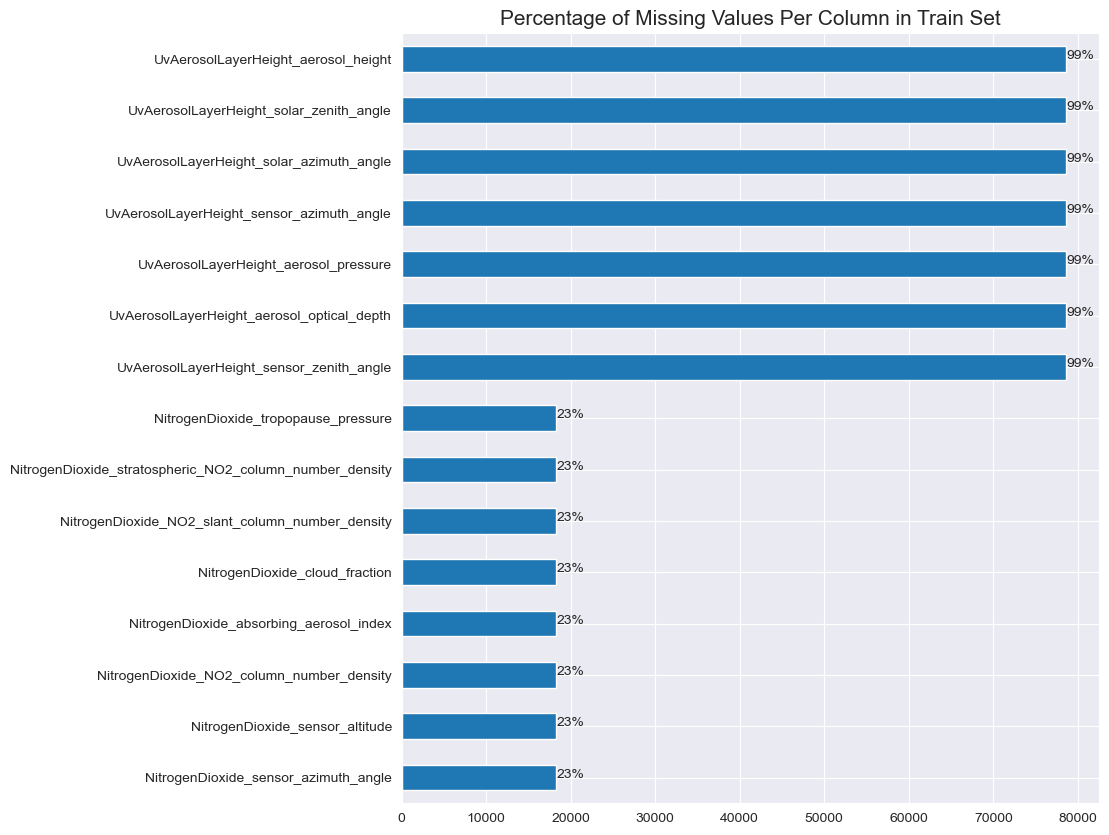

In [22]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False) [:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage = '{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width , height = p.get_width(), p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [23]:
#Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

In [24]:
#Data features EDA

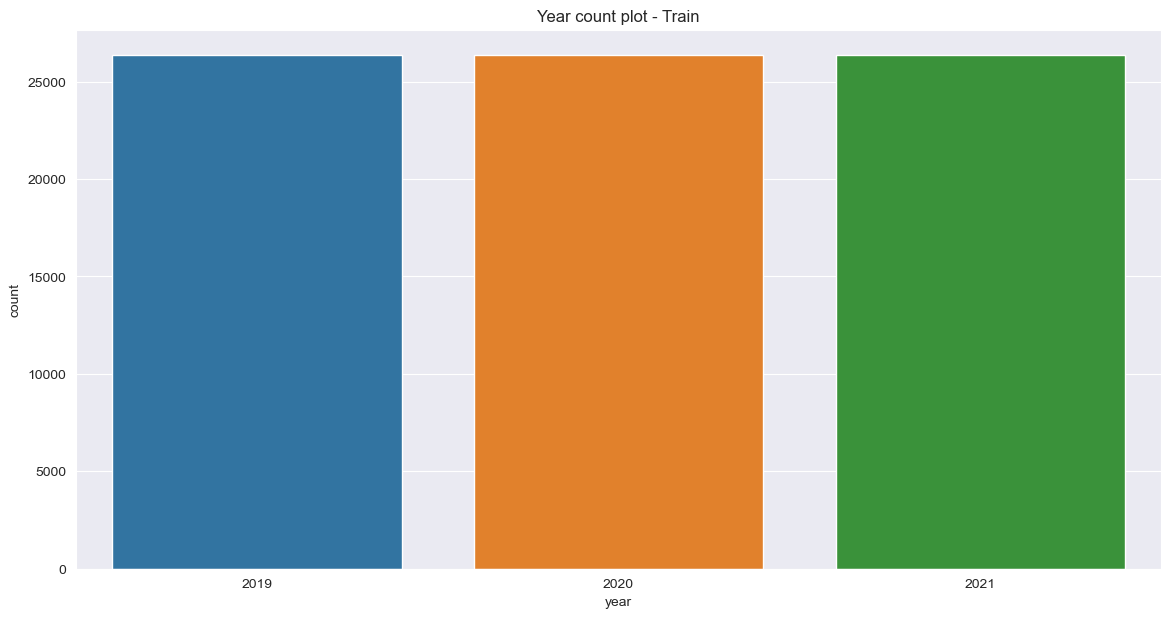

In [25]:
#Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train) #注意'year'是train其中一欄的名子，這個不能改
plt.title('Year count plot - Train')
plt.show()

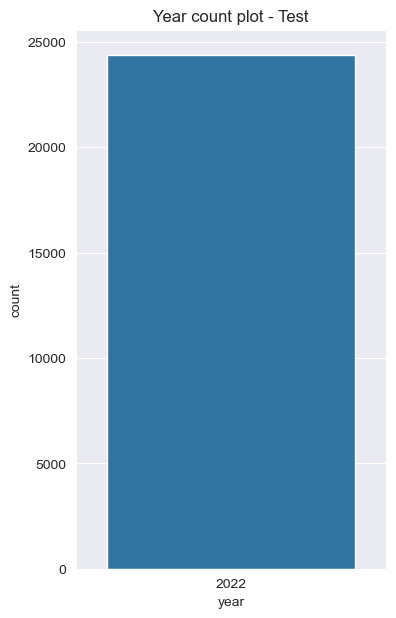

In [26]:
# Year countplot
plt.figure(figsize = (4, 7))
sns.countplot(x = 'year', data = test)
plt.title('Year count plot - Test')
plt.show()

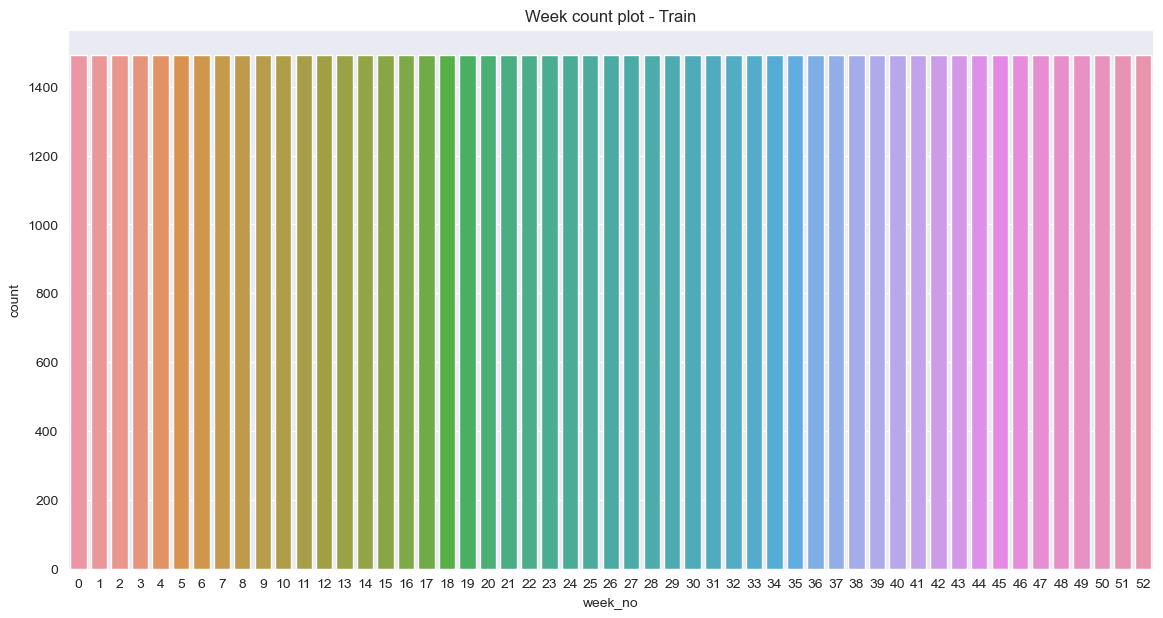

'\nThe number of observations of CO2 emissions are relatively the same across the weeks\n'

In [27]:
# Weak countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train) #week_no是train其中一欄
plt.title('Week count plot - Train')
plt.show()
"""
The number of observations of CO2 emissions are relatively the same across the weeks
"""

In [28]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,53
2020,53
2021,53


In [29]:
#Correlations - EDA

In [30]:
"""
這一段程式碼非常重要，因為它顯示出前20個跟emission最相關的幾個特徵。
"""
#Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                        1.0
longitude                                                   0.10275
UvAerosolLayerHeight_aerosol_height                        0.069008
UvAerosolLayerHeight_aerosol_pressure                      0.068138
Cloud_surface_albedo                                       0.046587
CarbonMonoxide_H2O_column_number_density                   0.043217
CarbonMonoxide_CO_column_number_density                    0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf   0.040263
UvAerosolLayerHeight_aerosol_optical_depth                 0.040156
UvAerosolLayerHeight_sensor_azimuth_angle                  0.035142
NitrogenDioxide_solar_azimuth_angle                        0.033417
Formaldehyde_tropospheric_HCHO_column_number_density       0.033333
SulphurDioxide_solar_azimuth_angle                         0.032338
Formaldehyde_solar_azimuth_angle                           0.030815
NitrogenDioxide_sensor_altitude                 

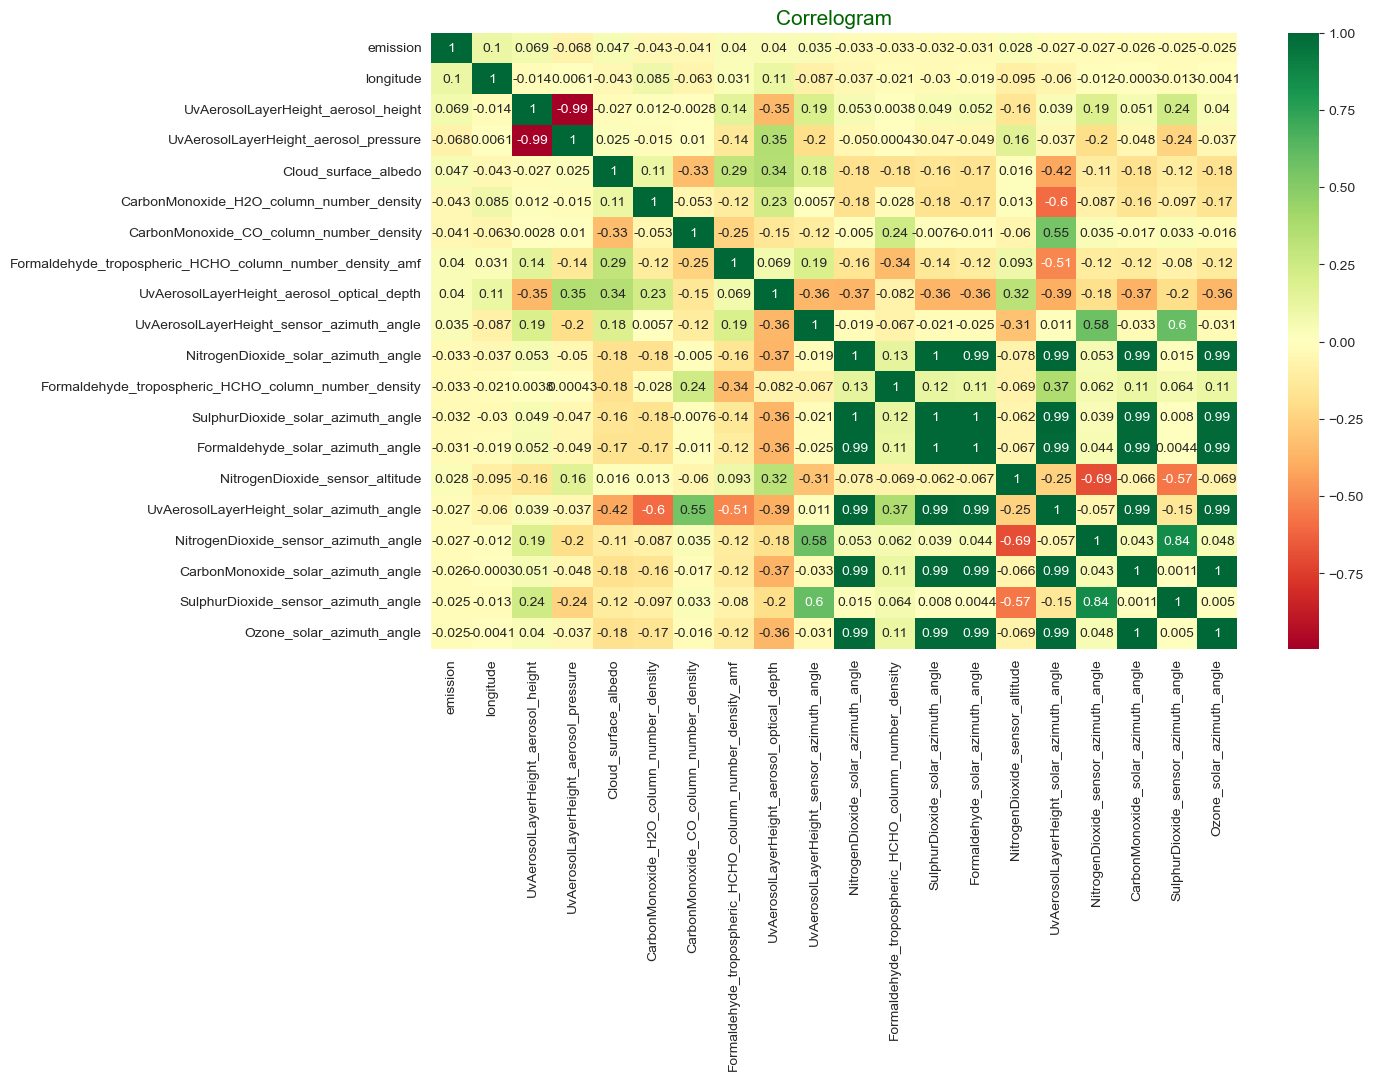

In [31]:
#Quantify correlations between features
corr = train[list(top20_corrs.index)].corr() #把剛剛的前20個轉成list，再當作train的index印出來
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap = 'RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen') #'darkgreen'就是設定相關係數為1時應該是什麼顏色。
plt.show()

In [32]:
#Timeseries visualization - EDA
"""
令人最興奮的地方!!
"""

'\n令人最興奮的地方!!\n'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


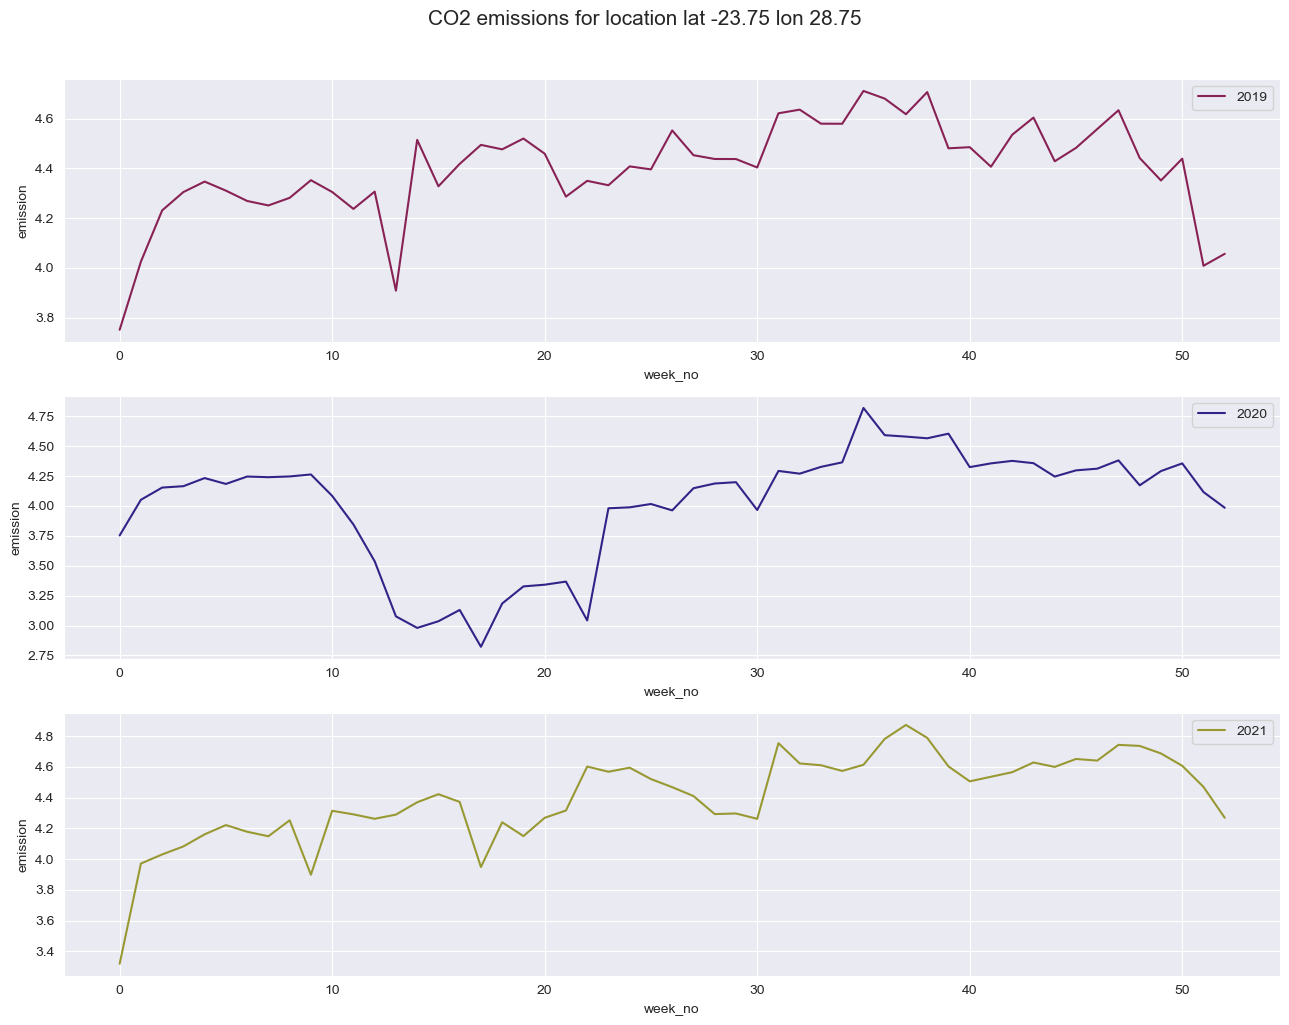

In [33]:
#Sample a unique location and visualize its emissions across the years
train.latitude, train.longtitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -0.510) & (train.longitude == 29.290)] #這是train前5筆資造裡面看到的一個地點

#Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (13, 10))
fig.suptitle('CO2 emissions for location lat -23.75 lon 28.75', y= 1.02, fontsize = 15)

#注意這裡zip是一一對應，像拉鍊一樣
for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288','#999933','orangered']):
    df = sample_loc[sample_loc.year == year]
    sns.lineplot(x=df.week_no, y=df.emission, ax = ax, label = year, color = color)
    plt.legend()
    plt.tight_layout()

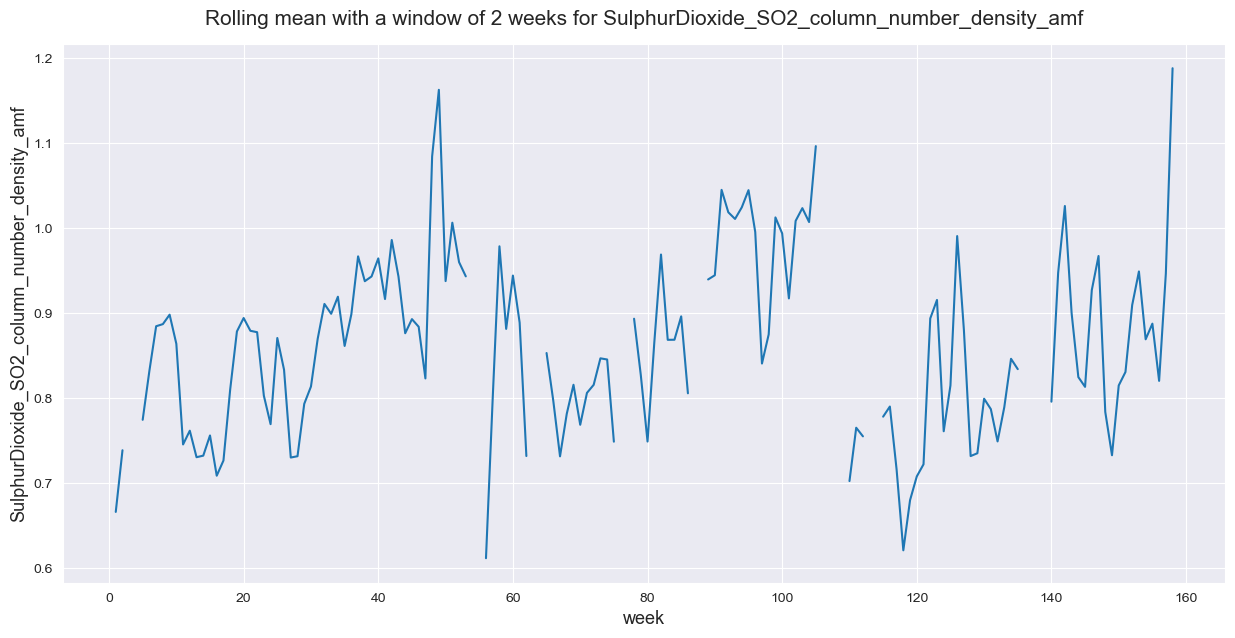

In [34]:
"""
注意，我們從EDA開始，畫出CO2的emission一直都只有單一地點而已，但我們實際上需要多個地點。
"""
#特徵工程的例子 : Aggregations, cumulative differences, moving averages ...
# 讓我們探索滾動平均值
#首先創造一個unique的經緯度，就是train再額外加一個欄叫做'location'.
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

#基於地點的filter，也就是說我要找特定地點的observation作為example
example_loc = train[train.location == '-0.51_29.29'] 
#我只取'-0.51_29.29'
#我有點擔心我們將經緯度只留下小數點後兩位的做法會讓我們在查詢的時候漏掉一些點

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
"""重要程式碼: 計算rolling mean的方法!!!"""
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualing rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y =1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

In [35]:
"""
With more research and domain knowledge generate useful features that can improve your model performance

Other examples of feature engineering:

1. Creating cluster regions
2. Interactions between different pollutatnts - ratios, additions,subtractions...
3. Time series features
"""

'\nWith more research and domain knowledge generate useful features that can improve your model performance\n\nOther examples of feature engineering:\n\n1. Creating cluster regions\n2. Interactions between different pollutatnts - ratios, additions,subtractions...\n3. Time series features\n'

In [36]:
"""
這裡最難懂!!!
"""
# Generate the above feature - rolling mean for all locations for both the train and test

#Feature engineering train
"""這一列不懂"""
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
               
"""這一列不懂"""
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
#下面這一列程式碼增加各種氣體在特定week_no滾動平均的欄位:
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns] 

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
"""這一列不懂"""
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
"""這一列不懂"""
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
#下面這一列程式碼增加各種氣體在特定week_no滾動平均的欄位:
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.2281e+04,7474.2,4.7982e+04,6474.2,9.692,0.26695,-65.312,38.05,-135.84,32.396
2,0.00030824,0.64814,0.0002107,0.039935,17.092,27.745,-138.72,29.475,0.00010515,0.037718,...,4.1336e+04,7730.5,4.6961e+04,6730.5,11.101,0.28012,4.2885,44.17,-141.71,28.878
3,0.00025527,0.65101,0.00017447,0.14045,15.057,49.376,-144.95,25.931,7.3221e-05,0.038769,...,4.2494e+04,7499.8,4.8326e+04,6499.8,11.259,0.2859,7.3111,44.038,-139.91,28.174
4,1.6513e-05,0.63872,2.9555e-05,0.20269,74.18,37.254,-144.4,23.067,8.15e-06,0.039488,...,4.8725e+04,6432.0,5.5271e+04,5432.0,12.415,0.29445,-18.686,36.132,-135.26,27.941


In [37]:
# Merge engineered features with train and test set
"""為什麼會增加欄的數量近兩倍??? 因為每一個氣體排放量旁邊都加了該時間點的一個滾動平均數"""
#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.00045592,0.69116,0.00031558,0.0,76.239,...,4.2281e+04,7474.2,4.7982e+04,6474.2,9.692,0.26695,-65.312,38.05,-135.84,32.396
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.00016056,0.60511,0.00010582,0.07987,-42.055,...,4.1336e+04,7730.5,4.6961e+04,6730.5,11.101,0.28012,4.2885,44.17,-141.71,28.878
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.00034998,0.69692,0.00024311,0.20103,72.17,...,4.2494e+04,7499.8,4.8326e+04,6499.8,11.259,0.2859,7.3111,44.038,-139.91,28.174
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.00031696,0.58053,-0.000184,0.20435,76.191,...,4.8725e+04,6432.0,5.5271e+04,5432.0,12.415,0.29445,-18.686,36.132,-135.26,27.941


In [38]:
pd.set_option('display.max_columns', None)
train_eng.head(10) #有'emission'這一個名稱的欄位

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,location,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_

In [39]:
test_eng.head() #注意它比起Train_eng少了一欄，因為沒有"emission".

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,location,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_troposphe

In [40]:
train_eng["latitude"].value_counts()
train_eng["longitude"].value_counts()

29.601    636
30.029    477
30.245    477
30.647    318
29.168    318
29.33     318
30.734    318
29.5      318
29.898    318
28.811    318
28.467    318
30.971    318
28.977    318
29.926    318
30.603    318
29.145    318
28.547    318
30.19     318
30.364    318
29.218    318
29.617    318
29.722    318
29.404    318
29.995    318
30.285    318
30.932    318
29.883    318
29.178    318
30.763    318
30.341    318
28.872    318
30.281    318
30.471    318
28.461    318
30.138    318
28.724    318
30.621    318
30.03     318
29.798    318
28.753    318
30.515    159
30.917    159
30.765    159
28.652    159
30.223    159
28.404    159
29.506    159
30.446    159
29.62     159
28.645    159
29.29     159
29.018    159
28.744    159
29.787    159
30.638    159
30.847    159
29.665    159
29.458    159
29.059    159
30.071    159
29.57     159
28.671    159
31.181    159
28.883    159
29.489    159
30.243    159
30.996    159
29.609    159
29.507    159
29.92     159
30.231    159
29.933

In [41]:
train_eng["emission"].isnull().sum() #全部都有values

0

In [42]:
#特定經緯度的CO2 emission
train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["emission"].shape


(159,)

In [43]:
train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["week_no"]
"""
他的week_no一年有重複一次，絕對不能直接用!!要先轉成三年的總week數
"""

'\n他的week_no一年有重複一次，絕對不能直接用!!要先轉成三年的總week數\n'

In [44]:
week_total = train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["week_no"].shape[0]
total_week_no = pd.Series(range(week_total))
print(total_week_no.shape)
display(total_week_no)

(159,)


0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
12      12
13      13
14      14
15      15
16      16
17      17
18      18
19      19
20      20
21      21
22      22
23      23
24      24
25      25
26      26
27      27
28      28
29      29
30      30
31      31
32      32
33      33
34      34
35      35
36      36
37      37
38      38
39      39
40      40
41      41
42      42
43      43
44      44
45      45
46      46
47      47
48      48
49      49
50      50
51      51
52      52
53      53
54      54
55      55
56      56
57      57
58      58
59      59
60      60
61      61
62      62
63      63
64      64
65      65
66      66
67      67
68      68
69      69
70      70
71      71
72      72
73      73
74      74
75      75
76      76
77      77
78      78
79      79
80      80
81      81
82      82
83      83
84      84
85      85
86      86
87      87
88      88
89      89
90      90

In [45]:
"""上面幾行的特徵工程主要是做滾動平均還有"""

'上面幾行的特徵工程主要是做滾動平均還有'

In [46]:
"""
這裡用randomforest
"""

"""
#選出"互相獨立"的特徵和target variable(i.e. emission)
#下面將NA值替換成0
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

#Instantiating the model
#n_jobs: 這是用於訓練模型的並行工作數。設置為-1表示使用所有可用的CPU核心來並行處理，這有助於加速模型的訓練過程。

clf = RandomForestRegressor(random_state = SEED, n_jobs = -1)
clf.fit(X_train, y_train)

#Making predictions
y_pred = clf.predict(X_test) #這是要給我們看proformance用的

#Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared = False)}' )
"""

'\n#選出"互相獨立"的特徵和target variable(i.e. emission)\n#下面將NA值替換成0\nX = train_eng.drop([\'ID_LAT_LON_YEAR_WEEK\', \'location\', \'emission\'], axis = 1).fillna(0)\ny = train_eng.emission\n\n#Splitting the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)\n\n#Instantiating the model\n#n_jobs: 這是用於訓練模型的並行工作數。設置為-1表示使用所有可用的CPU核心來並行處理，這有助於加速模型的訓練過程。\n\nclf = RandomForestRegressor(random_state = SEED, n_jobs = -1)\nclf.fit(X_train, y_train)\n\n#Making predictions\ny_pred = clf.predict(X_test) #這是要給我們看proformance用的\n\n#Measuring the accuracy of the model\nprint(f\'RMSE Score: {mean_squared_error(y_test, y_pred, squared = False)}\' )\n'

In [47]:
#X_test.head()

In [48]:
"""
To do list:
1. Imputation of CO2 emission data.
2. Moving average and preliminary prediction.
3. Use ML method to predict.
"""

'\nTo do list:\n1. Imputation of CO2 emission data.\n2. Moving average and preliminary prediction.\n3. Use ML method to predict.\n'

In [49]:
"""
如果你希望將其他氣體的排放納入模型中，有幾種方法可以考慮：

1. **Feature Engineering**: 在建立模型之前，你可以進行特徵工程，從其他氣體排放數據中創建新的特徵，這些特徵可能與二氧化碳排放有關。例如，你可以計算不同氣體排放之間的相對比例，或者創建時間特徵，如每年的氣體排放增長率。

2. **Multivariate Time Series Model**: 如果你的數據是多變量時間序列數據，你可以考慮使用支持多變量的時間序列模型。一個常見的選擇是Vector Autoregression (VAR) 模型，它允許你在同一模型中處理多個相關時間序列。這樣的模型可以捕捉不同氣體排放之間的相互作用。

3. **Deep Learning Models**: 你也可以考慮使用深度學習模型，如長短期記憶網絡（LSTM）或卷積神經網絡（CNN）。這些模型能夠處理多變量時間序列數據，並且可以學習不同氣體排放之間的複雜關係。

4. **Ensemble Methods**: 如果你的模型預測主要是基於二氧化碳的排放，但你仍然希望利用其他氣體的信息，可以考慮使用集成方法。例如，你可以將單變量的二氧化碳預測與多變量的其他氣體預測進行結合，以得到綜合的預測結果。

請注意，選擇哪種方法取決於你的數據特性、預測目標和預測準確性需求。你可以根據對數據的理解和模型驗證結果來選擇最適合的方法。
"""

'\n如果你希望將其他氣體的排放納入模型中，有幾種方法可以考慮：\n\n1. **Feature Engineering**: 在建立模型之前，你可以進行特徵工程，從其他氣體排放數據中創建新的特徵，這些特徵可能與二氧化碳排放有關。例如，你可以計算不同氣體排放之間的相對比例，或者創建時間特徵，如每年的氣體排放增長率。\n\n2. **Multivariate Time Series Model**: 如果你的數據是多變量時間序列數據，你可以考慮使用支持多變量的時間序列模型。一個常見的選擇是Vector Autoregression (VAR) 模型，它允許你在同一模型中處理多個相關時間序列。這樣的模型可以捕捉不同氣體排放之間的相互作用。\n\n3. **Deep Learning Models**: 你也可以考慮使用深度學習模型，如長短期記憶網絡（LSTM）或卷積神經網絡（CNN）。這些模型能夠處理多變量時間序列數據，並且可以學習不同氣體排放之間的複雜關係。\n\n4. **Ensemble Methods**: 如果你的模型預測主要是基於二氧化碳的排放，但你仍然希望利用其他氣體的信息，可以考慮使用集成方法。例如，你可以將單變量的二氧化碳預測與多變量的其他氣體預測進行結合，以得到綜合的預測結果。\n\n請注意，選擇哪種方法取決於你的數據特性、預測目標和預測準確性需求。你可以根據對數據的理解和模型驗證結果來選擇最適合的方法。\n'

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)
    
    # Draw the graph on screen
    plt.show()

In [52]:
"""重要"""
"""
comment: series的資料必須隨地點改變!!!
"""
time = total_week_no #這幾年的累積禮拜數(不會在年初從頭算)
series = train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["emission"] #特定經緯度的CO2 emission

# Define the split time
split_time = 104

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [53]:
print("time.shape = ",time.shape)
print("series.shape = ",series.shape)

time.shape =  (159,)
series.shape =  (159,)


In [54]:
time.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [55]:
# Parameters
window_size = 4
batch_size = 3 #32
shuffle_buffer_size = 100

In [56]:
""""超重要"""
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    #dataset = dataset.batch(batch_size).prefetch(1)
    dataset = dataset.prefetch(1)
    return dataset

In [57]:
dat_test = windowed_dataset(x_train, window_size, batch_size = 999, shuffle_buffer = shuffle_buffer_size)
for item in dat_test:
    print("item[0] = ",item[0])
    print("item[1] = ",item[1])
    

item[0] =  tf.Tensor([4.2693343 4.251361  4.2819366 4.3529334], shape=(4,), dtype=float64)
item[1] =  tf.Tensor(4.305424, shape=(), dtype=float64)
item[0] =  tf.Tensor([4.263746  4.0846295 3.8454564 3.537482 ], shape=(4,), dtype=float64)
item[1] =  tf.Tensor(3.0767941, shape=(), dtype=float64)
item[0] =  tf.Tensor([4.535888  4.6048665 4.4290185 4.4828773], shape=(4,), dtype=float64)
item[1] =  tf.Tensor(4.5586553, shape=(), dtype=float64)
item[0] =  tf.Tensor([4.418508  4.4949617 4.4770775 4.520477 ], shape=(4,), dtype=float64)
item[1] =  tf.Tensor(4.4595714, shape=(), dtype=float64)
item[0] =  tf.Tensor([4.0251765 4.231381  4.3052855 4.347317 ], shape=(4,), dtype=float64)
item[1] =  tf.Tensor(4.3108187, shape=(), dtype=float64)
item[0] =  tf.Tensor([4.377458  4.3582444 4.246167  4.2981043], shape=(4,), dtype=float64)
item[1] =  tf.Tensor(4.3121595, shape=(), dtype=float64)
item[0] =  tf.Tensor([4.28684  4.350335 4.332584 4.408427], shape=(4,), dtype=float64)
item[1] =  tf.Tensor(4.396

In [58]:
"""
coordinates = zip(train_eng["latitude"],train_eng["longitude"])
coordinates = list(coordinates)
coordinates = set(coordinates)
coordinates = list(coordinates)


#print("len(coordinates) = ",len(coordinates)) #恰好497個地點，證明這個方法是正確的!!!
#print("First location is ",coordinates[0])
#print("First location is ",tf.convert_to_tensor(coordinates[0]))
for coor in coordinates:
    print(tf.convert_to_tensor(coor))
"""

'\ncoordinates = zip(train_eng["latitude"],train_eng["longitude"])\ncoordinates = list(coordinates)\ncoordinates = set(coordinates)\ncoordinates = list(coordinates)\n\n\n#print("len(coordinates) = ",len(coordinates)) #恰好497個地點，證明這個方法是正確的!!!\n#print("First location is ",coordinates[0])\n#print("First location is ",tf.convert_to_tensor(coordinates[0]))\nfor coor in coordinates:\n    print(tf.convert_to_tensor(coor))\n'

In [59]:
#製作把經緯度考慮進去的dataset

coordinates = zip(train_eng["latitude"],train_eng["longitude"])
coordinates = list(coordinates)
coordinates = set(coordinates)
coordinates = list(coordinates) #497個地點
"""
這裡先只取一兩個，看看學得怎麼樣?
"""
coordinates = coordinates #[:10]

#寫一個函數輸入經緯度就可以獲得該經緯度的時間序列資料
"""
comment : 你的時間序列沒有隨著你的地點改變!!!!
"""
"""
非常注意!!
這裡的batch_size變數必須要整除資料筆數，否則會出現batch的大小不一樣大的情形，這樣無法變成dataset的資料型式。e.g. batch_size = 5就不行，因為不能整除。
"""

#batch_size = 20
def dataset_from_location(lat_and_long):
    """
    Input: lat_and_long : (latitude, longitude) ,a tuple with latitude and longitude in datatype = float.
    
    Output: Batched Tensorflow dataset.
    
    """
    
    week_total = train_eng.loc[(train_eng.latitude == lat_and_long[0]) & (train_eng.longitude == lat_and_long[1])]["week_no"].shape[0]
    total_week_no = pd.Series(range(week_total))
    
    time = total_week_no #這幾年的累積禮拜數(不會在年初從頭算)
    series = train_eng.loc[(train_eng.latitude == lat_and_long[0]) & (train_eng.longitude == lat_and_long[1])]["emission"] #特定經緯度的CO2 emission

    # Define the split time
    split_time = 104

    # Get the train set
    time_train = time[:split_time]
    x_train = series[:split_time]

    # Get the validation set
    time_valid = time[split_time:]
    x_valid = series[split_time:]
    
    # Generate the dataset windows
    dataset_ = windowed_dataset(x_train, window_size, batch_size = 9999 , shuffle_buffer = shuffle_buffer_size)
    
    tensor_list_1 = []
    tensor_list_2 = []

    for batch_features, batch_labels in dataset_: 
        #concat datas one by one
        coor_reshape = tf.reshape( tf.convert_to_tensor(lat_and_long), [2])#coor_reshape = tf.reshape( tf.convert_to_tensor(lat_and_long), [1,2])
        
        batch_feature = tf.cast(batch_features, tf.float32)#[np.newaxis]
        coor_reshape_repeat = coor_reshape #tf.repeat(coor_reshape, repeats = [batch_feature.shape[0]], axis=0)  
        
        #print("batch_feature.shape",batch_feature.shape)
        #print("coor_reshape_repeat.shape = ",coor_reshape_repeat.shape)
        
        concat = tf.concat([batch_feature, coor_reshape_repeat], axis =0) #axis = 1
        batch_label = tf.cast(batch_labels, tf.float32)

        #Append a single batch into lists 
        tensor_list_1.append(concat)
        tensor_list_2.append(batch_label)

    # Convert the lists to tensors
    tensor_list_1 = [tf.convert_to_tensor(tensor) for tensor in tensor_list_1]
    tensor_list_2 = [tf.convert_to_tensor(tensor) for tensor in tensor_list_2]
    #print("len of list", len(tensor_list_1))

    # Create a new dataset using from_tensor_slices
    new_dataset = tf.data.Dataset.from_tensor_slices((tensor_list_1, tensor_list_2)).batch(batch_size).prefetch(1)
    
    return new_dataset

#Let's try an example
lat_and_long = coordinates[0]
print("coordinates = ", lat_and_long)
dataset_example = dataset_from_location(lat_and_long)

# Print the elements of the new dataset
for train,label in dataset_example:
    print("train = ", train.shape)
    print("label = ",label.shape)
    

coordinates =  (-0.79, 30.607)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  

In [60]:
# 獲得訓練集!!!
whole_data = dataset_from_location(next(iter(coordinates)))
for coor in coordinates[1:]:
    whole_data.concatenate(dataset_from_location(coor))

for train,label in whole_data:
    print("train = ", train.shape)
    print("label = ",label.shape)

train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (3, 6)
label =  (3,)
train =  (

In [61]:
#自訂loss函數和懲罰項
"""
def custom_loss(y_true, y_pred):
    # Define a regularization factor
    reg_factor = 0.01
    
    # Calculate the mean squared error
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    
    # Calculate the regularization term (output squared)
    reg_term = tf.reduce_mean(tf.square(y_pred))
    
    # Combine the mean squared error and regularization term
    total_loss = mse + reg_factor * reg_term
    
    return total_loss
"""
"""
用法 : model_baseline.compile(loss=custom_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=2 * 1e-4)) 
"""

'\n用法 : model_baseline.compile(loss=custom_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=2 * 1e-4)) \n'

In [62]:
#from keras import regularizers
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size + 2]),#tf.keras.layers.Dense(10, input_shape=[window_size + 2]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(1) 
])
# Print the model summary
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 80)                1680      
                                                                 
 dense_3 (Dense)             (None, 1)                 81        
                                                        

In [63]:
# Build the model
"""
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size + 2], activation="relu"),#tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()
"""

'\nmodel_baseline = tf.keras.models.Sequential([\n    tf.keras.layers.Dense(10, input_shape=[window_size + 2], activation="relu"),#tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),\n    tf.keras.layers.Dense(20, activation="relu"),\n    tf.keras.layers.Dense(40, activation="relu"),\n    tf.keras.layers.Dense(80, activation="relu"),\n    #tf.keras.layers.Dense(10, activation="relu"),\n    tf.keras.layers.Dense(1)\n])\n\n# Print the model summary\nmodel_baseline.summary()\n'

In [64]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4)) #learning_rate=2 * 1e-4 
#model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [65]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        tolorance = 20 #50 
        if(logs.get('loss') < tolorance): #< 2*1e-4 # Experiment with changing this value
            print(f"\nReached {tolorance} loss so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [73]:
# Train the model
first_10_samples = whole_data#.take(10)
print("type(first_10_samples) = ",type(first_10_samples))
model_baseline.fit(first_10_samples,epochs =100, verbose = 1, callbacks=[callbacks]) 
#model_baseline.fit(dataset,epochs=100)
#model_baseline.fit(whole_data,epochs =7000, callbacks=[callbacks]) #model_baseline.fit(dataset,epochs=100)

type(first_10_samples) =  <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100
34/34 [==============================] - 0s 3ms/step - loss: 68.5130
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 64.0859
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 62.5759
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 61.6993
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 60.4060
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 59.8114
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 59.4065
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 59.0357
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 58.2977
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 56.9751
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 56.4594
Epoch 12/100
34/

34/34 [==============================] - 0s 3ms/step - loss: 52.0557
Epoch 100/100
34/34 [==============================] - 0s 3ms/step - loss: 52.0006


In [ ]:

def predict_from_location(lat_and_long):
    time = total_week_no #這幾年的累積禮拜數(不會在年初從頭算)
    series = train_eng.loc[(train_eng.latitude == lat_and_long[0]) & (train_eng.longitude == lat_and_long[1])]["emission"] #特定經緯度的CO2 emission

    # Define the split time
    split_time = 104

    # Get the train set
    time_train = time[:split_time]
    x_train = series[:split_time]

    # Get the validation set
    time_valid = time[split_time:]
    x_valid = series[split_time:]

    """沒有搞懂"""
    # Initialize a list
    forecast = []

    # Reduce the original series
    forecast_series = series[split_time - window_size:] #只有包含spliting time 以前的數據!!!
    print("len(forecast_series) = ",len(forecast_series))

    # Use the model to predict data points per window size
    forecast_series = forecast_series.to_numpy()
    print(type(forecast_series))


    for time in range(len(forecast_series) - window_size):
        #這裡把要forcast的序列和經緯度座標合併在一起
        forcast_and_location = np.append(forecast_series[time:time + window_size], np.array(coordinates[0]) ) [np.newaxis]
        #這裡把剛剛合併的資料丟到模型裡面做training，然後再把結果append給forcast序列(一個list)
        predict_ = model_baseline.predict(forcast_and_location)
        forecast.append(predict_)
        print("predict_ = ",predict_)

    # Convert to a numpy array and drop single dimensional axes
    results = np.array(forecast).squeeze()
    
    # Plot the results
    """
    print("time_valid = ",time_valid)
    print("len(time_valid) = ",len(time_valid))
    print("len(results) = ",len(results))
    """
    plot_series(time_train, x_train)
    plot_series(time_valid, (x_valid, results))
    
    # Compute the metrics
    print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
    print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
    return results

#Let's try an example
lat_and_long = coordinates[100]
print("coordinates = ", lat_and_long)
results = predict_from_location(lat_and_long)


In [ ]:
#tor = 65 lr = 1e-3
# 1 st layer with 1 neuron 108.8202 7.5480585 loss = 62.5375 at 687/5000
# 1 st layer with 2 neuron 1102.091 28.454443 loss = 64.0670 at 757/5000

# tor = 56 lr =1e-4
# 1 st layer with 2 neuron 404.7037 14.530484 loss =  49.4180 at 1/5000
# 1 st layer with 3 neuron 16xx 28 loss =  6x at ?/5000
# tor = 56 lr =1e-5